In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the CSV data into a DataFrame
df = pd.read_csv(r"merged_cohorts_df.csv")

In [3]:
# Create a new SQLite database
db_path = "sqlite:///merged_cohorts_df.db"
engine = create_engine(db_path)

In [4]:
# Clean the 'Percent Graduated in 4 Years' column
def clean_percent(value):
    if isinstance(value, str):
        value = value.replace('%', '').strip()  # Remove percentage sign
        if value.startswith('<'):
            return 0.0  # Handle cases like '< 2%'
        if value == '*':
            return 0.0  # Handle cases like '*'
    return float(value) if value.isnumeric() else 0.0

df['Percent Graduated in 4 Years'] = df['Percent Graduated in 4 Years'].apply(clean_percent)

In [5]:
# Create the necessary tables
with engine.connect() as connection:
    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Districts (
        district_ID INTEGER PRIMARY KEY,
        district_Name TEXT NOT NULL
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Subgroups (
        Subgroup_No INTEGER PRIMARY KEY,
        Subgroup_Name TEXT NOT NULL
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Schools (
        District_ID INTEGER,
        School_ID INTEGER,
        School_Name TEXT NOT NULL,
        PRIMARY KEY (School_ID, School_Name),
        FOREIGN KEY (District_ID) REFERENCES Districts(district_ID)
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Yr2023_Grad_Data (
        School_Name TEXT NOT NULL,
        Subgroup_Name TEXT NOT NULL,
        No_in_Class INTEGER, 
        No_Graduated INTEGER,
        Percent_Graduated FLOAT,
        PRIMARY KEY (School_Name, Subgroup_Name)
    )
    """))

# Assuming the DataFrame has the correct columns as needed:
df['Percent Graduated in 4 Years'] = df['Percent Graduated in 4 Years'].replace('*', 0).astype(float)
df.rename(columns={
    'LEA Name': 'District_Name',
    'School Entity ID': 'School_ID',
    'School Name': 'School_Name',
    'Subgroup': 'Subgroup_Name',
    'Number Graduated': 'No_Graduated',
    'Number in Cohort': 'No_in_Class',
    'Percent Graduated in 4 Years': 'Percent_Graduated'
}, inplace=True)

In [6]:
# Rename columns
df.rename(columns={
    'LEA Name': 'District_Name',
    'School Entity ID': 'School_ID',
    'School Name': 'School_Name',
    'Subgroup': 'Subgroup_Name',
    'Number Graduated': 'No_Graduated',
    'Number in Cohort': 'No_in_Class',
    'Percent Graduated in 4 Years': 'Percent_Graduated'
}, inplace=True)

In [7]:
# Create the necessary tables
with engine.connect() as connection:
    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Districts (
        district_ID INTEGER PRIMARY KEY,
        district_Name TEXT NOT NULL
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Subgroups (
        Subgroup_No INTEGER PRIMARY KEY,
        Subgroup_Name TEXT NOT NULL
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Schools (
        District_ID INTEGER,
        School_ID INTEGER,
        School_Name TEXT NOT NULL,
        PRIMARY KEY (School_ID, School_Name),
        FOREIGN KEY (District_ID) REFERENCES Districts(district_ID)
    )
    """))

    connection.execute(text("""
    CREATE TABLE IF NOT EXISTS Yr2023_Grad_Data (
        School_Name TEXT NOT NULL,
        Subgroup_Name TEXT NOT NULL,
        No_in_Class INTEGER, 
        No_Graduated INTEGER,
        Percent_Graduated FLOAT,
        PRIMARY KEY (School_Name, Subgroup_Name)
    )
    """))

In [8]:
# Insert unique districts into the Districts table
unique_districts = df[['District_Name']].drop_duplicates()
unique_districts['district_ID'] = range(1, len(unique_districts) + 1)
unique_districts.to_sql('Districts', con=engine, if_exists='replace', index=False)

332

In [9]:
# Insert unique subgroups into the Subgroups table
unique_subgroups = df[['Subgroup_Name']].drop_duplicates()
unique_subgroups['Subgroup_No'] = range(1, len(unique_subgroups) + 1)
unique_subgroups.to_sql('Subgroups', con=engine, if_exists='replace', index=False)

27

In [10]:
# Insert schools into the Schools table
df['District_ID'] = df['District_Name'].map(unique_districts.set_index('District_Name')['district_ID'])
df[['District_ID', 'School_ID', 'School_Name']].drop_duplicates().to_sql('Schools', con=engine, if_exists='replace', index=False)

687

In [11]:
# Insert graduation data into Yr2023_Grad_Data
df[['School_Name', 'Subgroup_Name', 'No_in_Class', 'No_Graduated', 'Percent_Graduated']].to_sql('Yr2023_Grad_Data', con=engine, if_exists='replace', index=False)

39208

In [12]:
# Function to execute a query and return results
def execute_query(query):
    return pd.read_sql(query, engine)

In [13]:
# 1. Overall graduation rate across all schools
overall_grad_rate_query = """
SELECT AVG(Percent_Graduated) as Overall_Graduation_Rate
FROM Yr2023_Grad_Data
"""
overall_grad_rate = execute_query(overall_grad_rate_query)
print("Overall Graduation Rate:\n", overall_grad_rate)


Overall Graduation Rate:
    Overall_Graduation_Rate
0                 4.902265


In [14]:
# 2. Graduation rate by subgroup
grad_rate_by_subgroup_query = """
SELECT Subgroup_Name, AVG(Percent_Graduated) as Avg_Graduation_Rate
FROM Yr2023_Grad_Data
GROUP BY Subgroup_Name
"""
grad_rate_by_subgroup = execute_query(grad_rate_by_subgroup_query)
print("\nGraduation Rate by Subgroup:\n", grad_rate_by_subgroup)


Graduation Rate by Subgroup:
                           Subgroup_Name  Avg_Graduation_Rate
0                                   All             6.684980
1      American Indian or Alaska Native             3.595467
2                                 Asian             8.971902
3                Black/African American             6.102151
4                             EL Cohort             2.520499
5                               ELFEP14             0.288714
6                            ELL Cohort             1.607339
7                      English Learners             0.253406
8                                Female             9.403740
9                           Foster Care             0.000000
10                   Foster Care Cohort             0.704668
11                   Hispanic or Latino             6.973086
12                             Homeless             0.000000
13                      Homeless Cohort             2.616697
14             Income Eligibility 1 & 2             2.

In [15]:
# 3. Top schools with highest graduation rates for specific subgroups
top_schools_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated
FROM Yr2023_Grad_Data
ORDER BY Percent_Graduated DESC
LIMIT 10
"""
top_schools = execute_query(top_schools_query)
print("\nTop Schools with Highest Graduation Rates:\n", top_schools)


Top Schools with Highest Graduation Rates:
                            School_Name               Subgroup_Name  \
0                 St Johns High School                        Male   
1                 St Johns High School  Income Eligibility 1 and 2   
2                   Benson High School          Hispanic or Latino   
3  Center for Academic Success, The #2                      Female   
4                     San Simon School                         All   
5                 St David High School                         All   
6                 St David High School                       White   
7                 St David High School  Income Eligibility 1 and 2   
8                Tombstone High School          Hispanic or Latino   
9             Valley Union High School                      Female   

   Percent_Graduated  
0              100.0  
1              100.0  
2              100.0  
3              100.0  
4              100.0  
5              100.0  
6              100.0  


In [16]:
# 4. Districts or schools with the largest gaps in graduation rates
gaps_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated,
       (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data g2 WHERE g2.School_Name = g1.School_Name) as Avg_School_Grad_Rate
FROM Yr2023_Grad_Data g1
WHERE Percent_Graduated < (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data)
ORDER BY Percent_Graduated
"""
gaps = execute_query(gaps_query)
print("\nSchools with Largest Gaps in Graduation Rates:\n", gaps)


Schools with Largest Gaps in Graduation Rates:
                                              School_Name  \
0                                     Chinle High School   
1                                     Chinle High School   
2                                     Chinle High School   
3                                     Chinle High School   
4                                     Chinle High School   
...                                                  ...   
36594   Career Success Jr/Sr High School - North Phoenix   
36595  Pima County Schools Superintendent's Diploma P...   
36596                             Sun Valley High School   
36597            Salt River Accelerated Learning Academy   
36598                   Intelli-School - Paradise Valley   

                          Subgroup_Name  Percent_Graduated  \
0                            ELL Cohort                0.0   
1                                   All                0.0   
2                                  Male     

In [17]:

# 5. Distribution of schools based on % of students who graduated
distribution_query = """
SELECT Percent_Graduated, COUNT(*) as Number_of_Schools
FROM Yr2023_Grad_Data
GROUP BY Percent_Graduated
ORDER BY Percent_Graduated
"""
distribution = execute_query(distribution_query)
print("\nDistribution of Schools Based on Graduation Rates:\n", distribution)


Distribution of Schools Based on Graduation Rates:
     Percent_Graduated  Number_of_Schools
0                 0.0              36594
1                 2.0                  1
2                 3.0                  1
3                 4.0                  3
4                 5.0                 10
..                ...                ...
83               95.0                 48
84               96.0                 47
85               97.0                 11
86               98.0                 14
87              100.0                828

[88 rows x 2 columns]


In [19]:
# Set up the Seaborn style
sns.set_theme(style="whitegrid")

In [22]:
# 1. Overall graduation rate across all schools
overall_grad_rate_query = """
SELECT AVG(Percent_Graduated) as Overall_Graduation_Rate
FROM Yr2023_Grad_Data
"""
overall_grad_rate = execute_query(overall_grad_rate_query)

# Print the overall graduation rate
print("Overall Graduation Rate:\n", overall_grad_rate)

Overall Graduation Rate:
    Overall_Graduation_Rate
0                 4.902265


In [23]:
# 2. Graduation rate by subgroup
grad_rate_by_subgroup_query = """
SELECT Subgroup_Name, AVG(Percent_Graduated) as Avg_Graduation_Rate
FROM Yr2023_Grad_Data
GROUP BY Subgroup_Name
"""
grad_rate_by_subgroup = execute_query(grad_rate_by_subgroup_query)

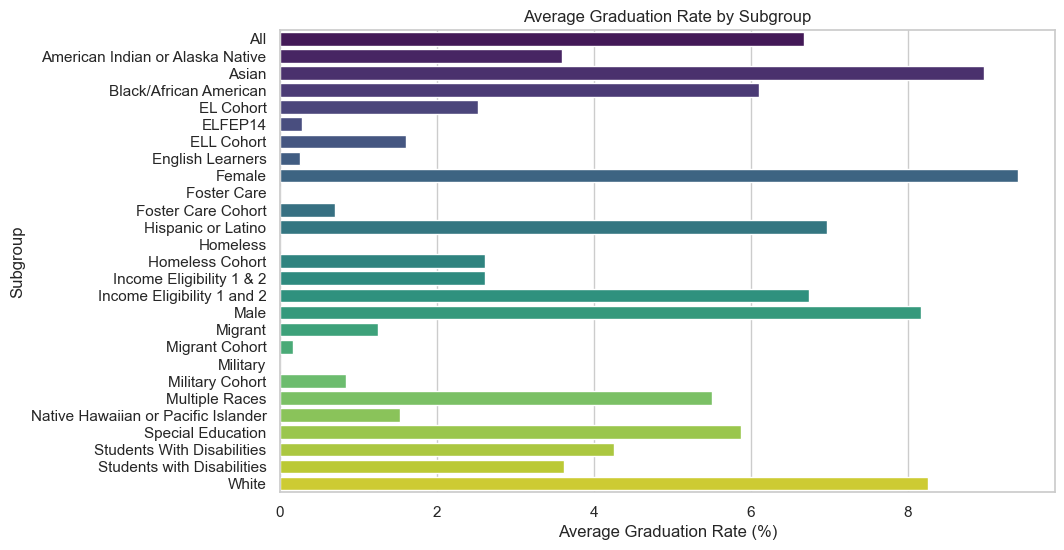

In [24]:
# Visualization of graduation rate by subgroup
plt.figure(figsize=(10, 6))
sns.barplot(data=grad_rate_by_subgroup, x='Avg_Graduation_Rate', y='Subgroup_Name', palette='viridis')
plt.title('Average Graduation Rate by Subgroup')
plt.xlabel('Average Graduation Rate (%)')
plt.ylabel('Subgroup')
plt.show()

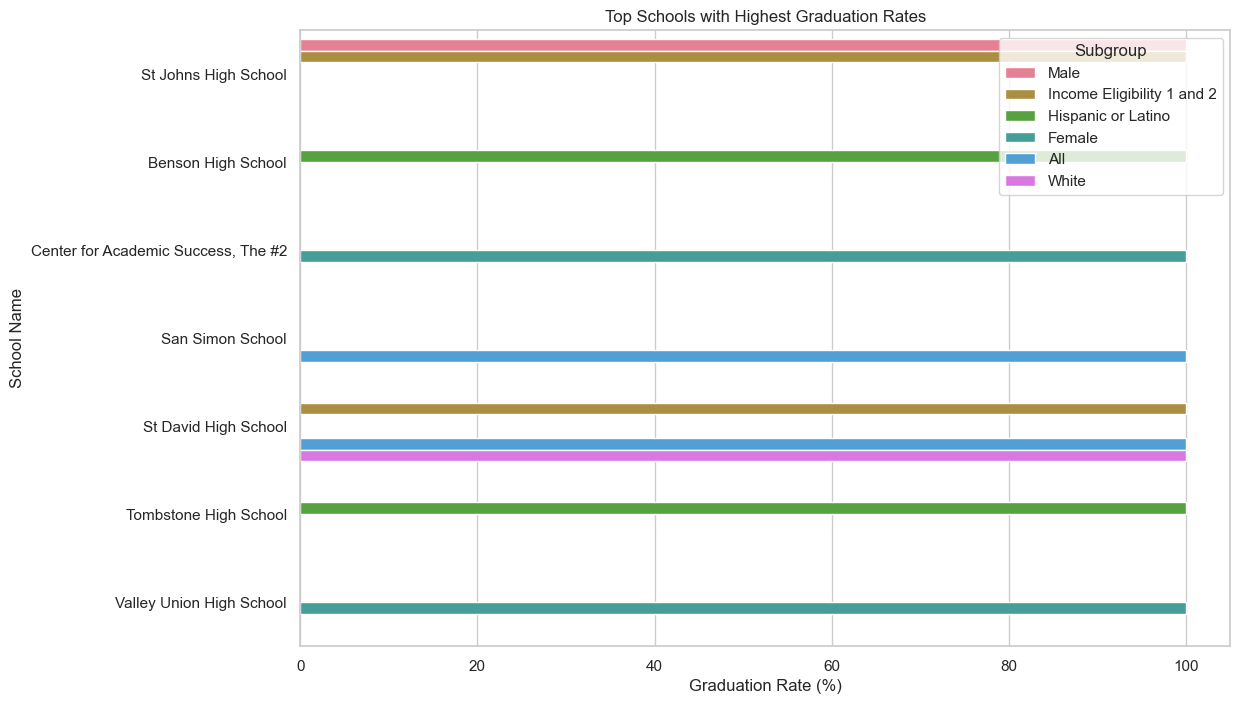

In [25]:
# 3. Top schools with highest graduation rates for specific subgroups
top_schools_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated
FROM Yr2023_Grad_Data
ORDER BY Percent_Graduated DESC
LIMIT 10
"""
top_schools = execute_query(top_schools_query)

# Visualization of top schools
plt.figure(figsize=(12, 8))
sns.barplot(data=top_schools, x='Percent_Graduated', y='School_Name', hue='Subgroup_Name', palette='husl')
plt.title('Top Schools with Highest Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('School Name')
plt.legend(title='Subgroup')
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


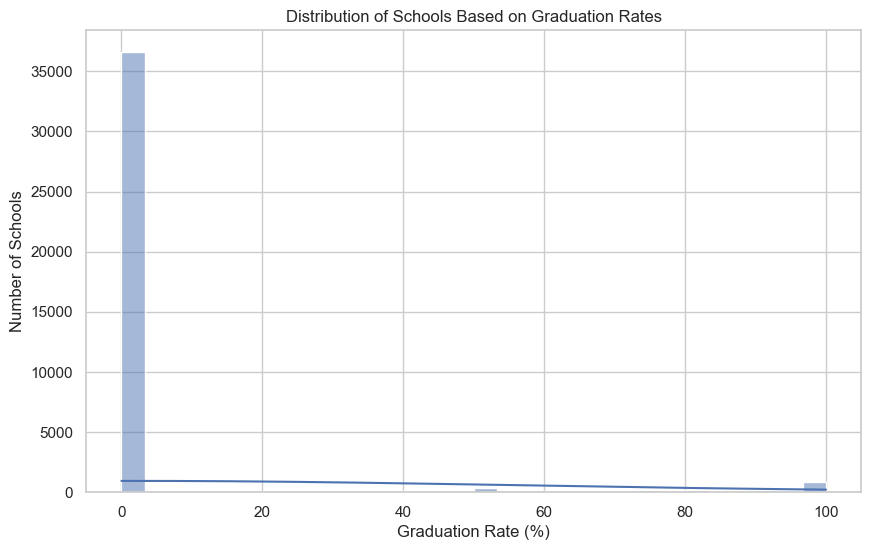

In [26]:
# 4. Distribution of schools based on % of students who graduated
distribution_query = """
SELECT Percent_Graduated, COUNT(*) as Number_of_Schools
FROM Yr2023_Grad_Data
GROUP BY Percent_Graduated
ORDER BY Percent_Graduated
"""
distribution = execute_query(distribution_query)

# Visualization of the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=distribution, x='Percent_Graduated', weights='Number_of_Schools', bins=30, kde=True)
plt.title('Distribution of Schools Based on Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Number of Schools')
plt.show()

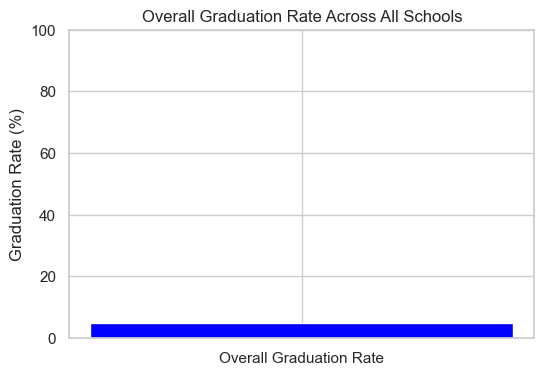

In [27]:
# Overall graduation rate
overall_grad_rate_query = """
SELECT AVG(Percent_Graduated) as Overall_Graduation_Rate
FROM Yr2023_Grad_Data
"""
overall_grad_rate = execute_query(overall_grad_rate_query)

# Visualization
plt.figure(figsize=(6, 4))
plt.bar(['Overall Graduation Rate'], overall_grad_rate['Overall_Graduation_Rate'], color='blue')
plt.title('Overall Graduation Rate Across All Schools')
plt.ylabel('Graduation Rate (%)')
plt.ylim(0, 100)
plt.show()

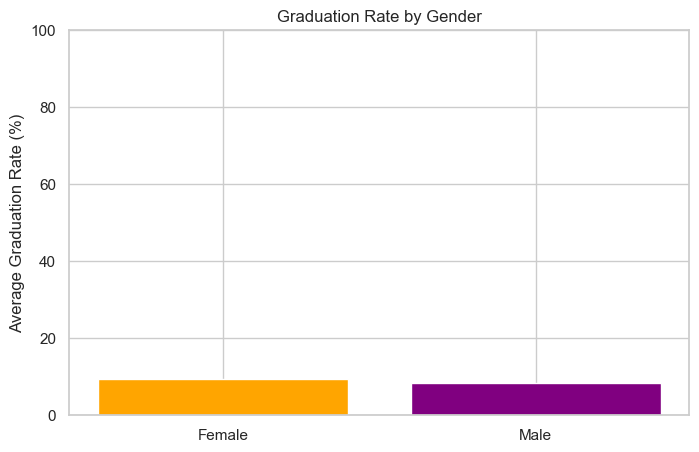

In [28]:
# Graduation rate by gender
grad_rate_by_gender_query = """
SELECT Subgroup_Name, AVG(Percent_Graduated) as Avg_Graduation_Rate
FROM Yr2023_Grad_Data
WHERE Subgroup_Name IN ('Male', 'Female')  -- Assuming these are your subgroup names
GROUP BY Subgroup_Name
"""
grad_rate_by_gender = execute_query(grad_rate_by_gender_query)

# Visualization
plt.figure(figsize=(8, 5))
plt.bar(grad_rate_by_gender['Subgroup_Name'], grad_rate_by_gender['Avg_Graduation_Rate'], color=['orange', 'purple'])
plt.title('Graduation Rate by Gender')
plt.ylabel('Average Graduation Rate (%)')
plt.ylim(0, 100)
plt.show()

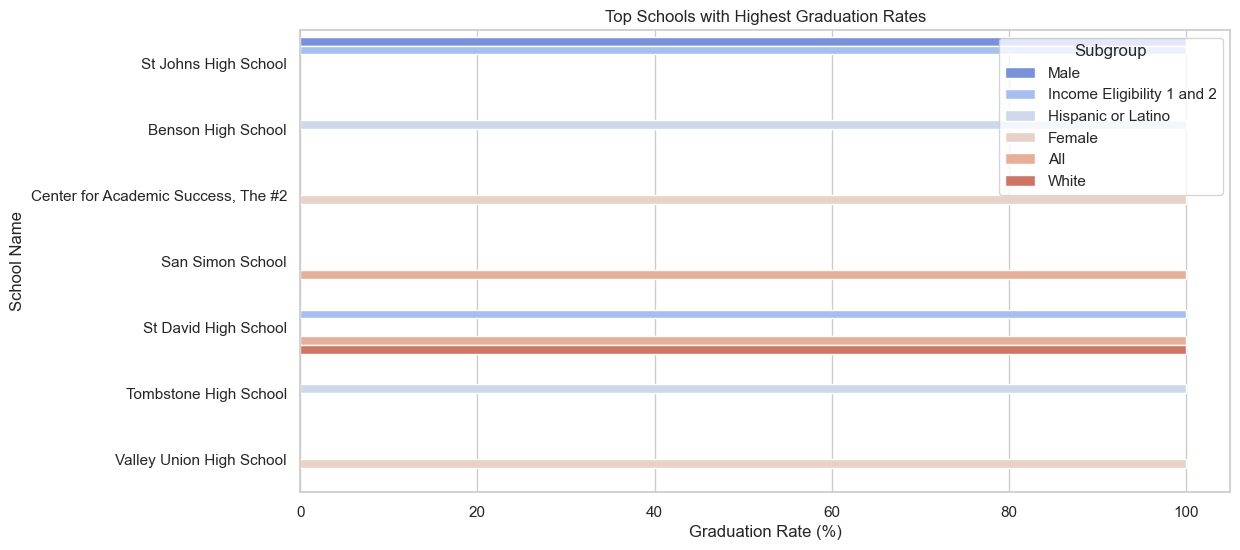

In [29]:
# Top schools with highest graduation rates for specific subgroups
top_schools_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated
FROM Yr2023_Grad_Data
ORDER BY Percent_Graduated DESC
LIMIT 10
"""
top_schools = execute_query(top_schools_query)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_schools, x='Percent_Graduated', y='School_Name', hue='Subgroup_Name', palette='coolwarm')
plt.title('Top Schools with Highest Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('School Name')
plt.legend(title='Subgroup')
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


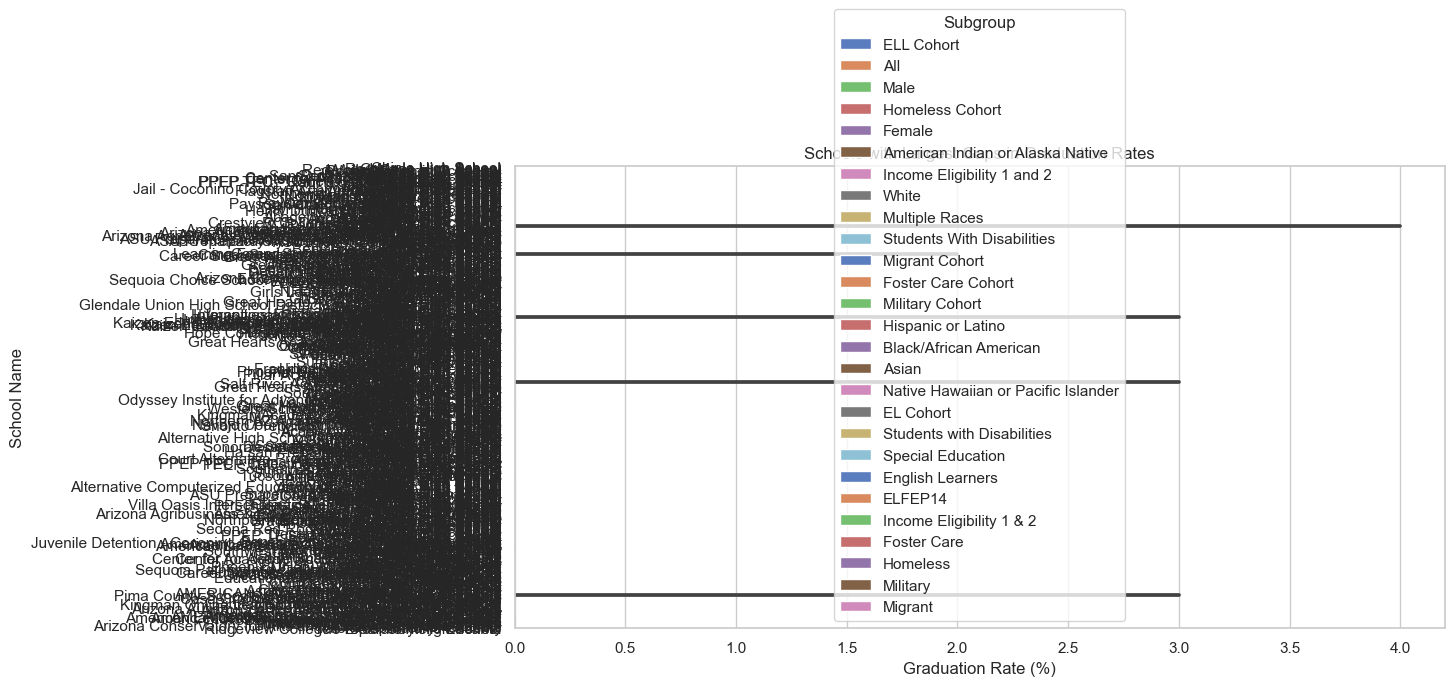

In [30]:
# Identify gaps in graduation rates
gaps_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated,
       (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data g2 WHERE g2.School_Name = g1.School_Name) as Avg_School_Grad_Rate
FROM Yr2023_Grad_Data g1
WHERE Percent_Graduated < (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data)
ORDER BY Percent_Graduated
"""
gaps = execute_query(gaps_query)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=gaps, x='Percent_Graduated', y='School_Name', hue='Subgroup_Name', palette='muted')
plt.title('Schools with Largest Gaps in Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('School Name')
plt.legend(title='Subgroup')
plt.show()

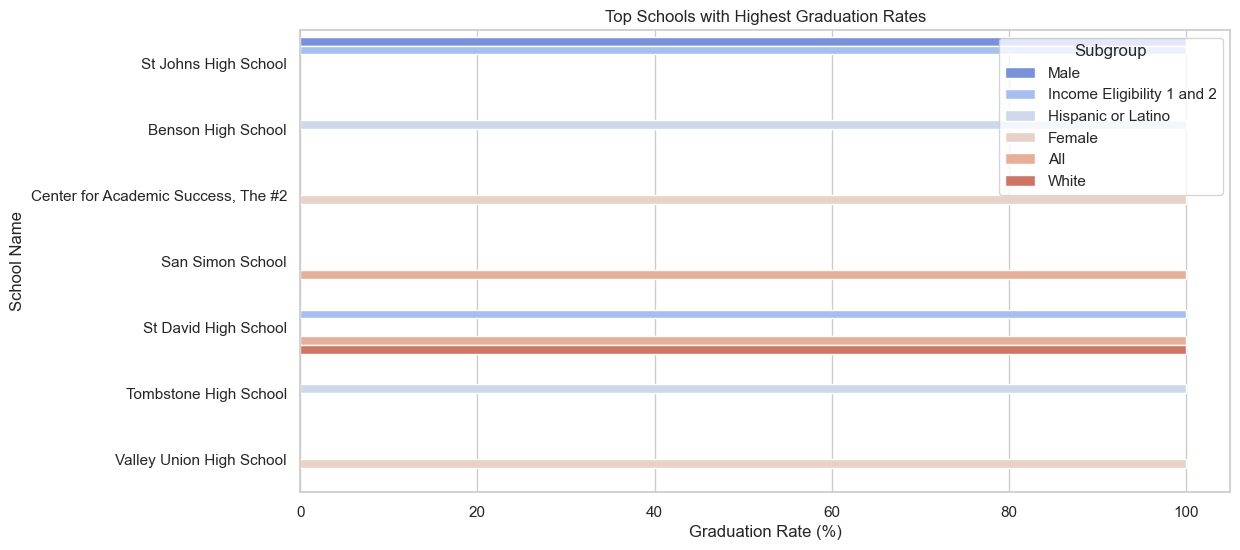

In [31]:
# Top schools with highest graduation rates for specific subgroups
top_schools_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated
FROM Yr2023_Grad_Data
ORDER BY Percent_Graduated DESC
LIMIT 10
"""
top_schools = execute_query(top_schools_query)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_schools, x='Percent_Graduated', y='School_Name', hue='Subgroup_Name', palette='coolwarm')
plt.title('Top Schools with Highest Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('School Name')
plt.legend(title='Subgroup')
plt.show()


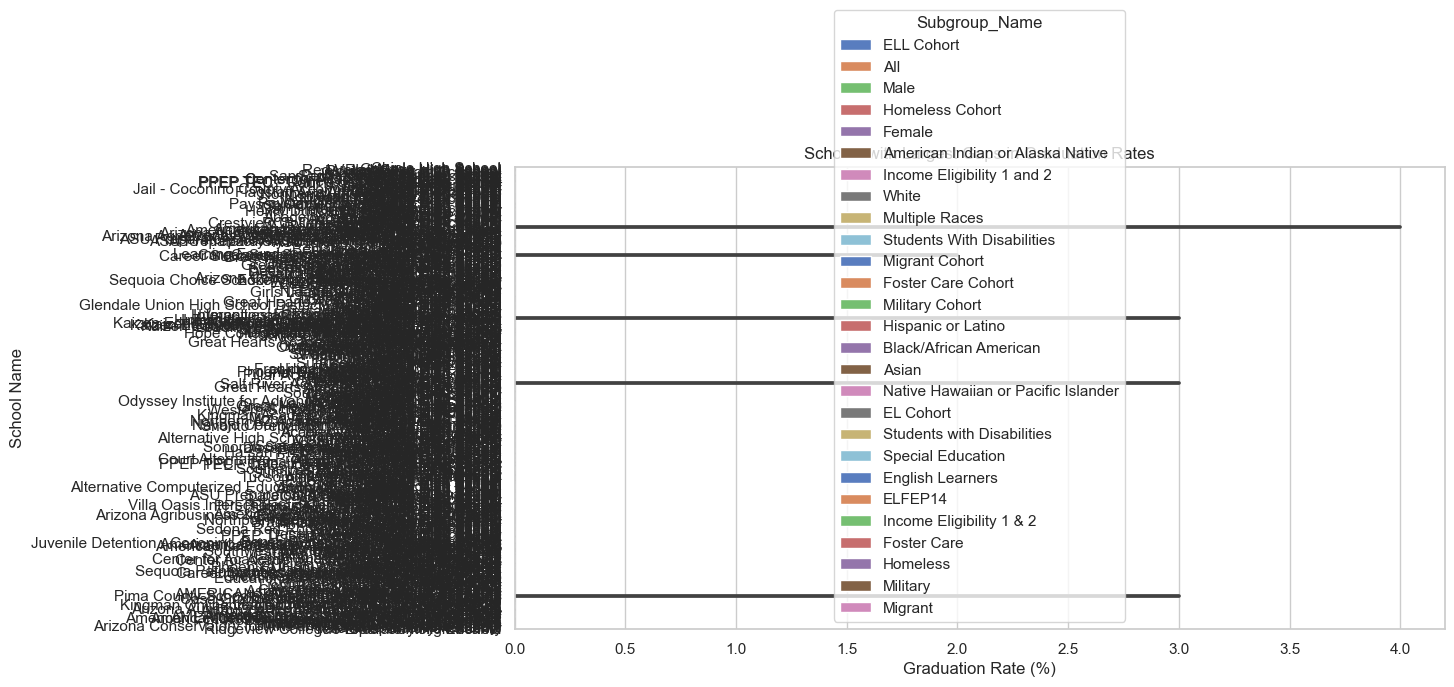

In [33]:
# Identify gaps in graduation rates
gaps_query = """
SELECT School_Name, Subgroup_Name, Percent_Graduated,
       (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data g2 WHERE g2.School_Name = g1.School_Name) as Avg_School_Grad_Rate
FROM Yr2023_Grad_Data g1
WHERE Percent_Graduated < (SELECT AVG(Percent_Graduated) FROM Yr2023_Grad_Data)
ORDER BY Percent_Graduated
"""
gaps = execute_query(gaps_query)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=gaps, x='Percent_Graduated', y='School_Name', hue='Subgroup_Name', palette='muted')
plt.title('Schools with Largest Gaps in Graduation Rates')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('School Name')
plt.show()
